
=== Metrics for Each Target ===
                 Target           MSE           MAE        R2
0  SO2TONS_per_LOADMWBA  3.040551e-10  1.317826e-05 -0.181411
1  SO2TONS_per_LOADMWBT  6.891597e-11  8.478984e-07 -0.531235
2  NH3TONS_per_LOADMWBA  1.713815e-07  1.697357e-04 -0.023292
3  NH3TONS_per_LOADMWBT  1.470984e-07  3.154515e-05 -0.014737
4  NOXTONS_per_LOADMWBA  1.554881e-06  3.387791e-04 -2.364729
5  NOXTONS_per_LOADMWBT  1.539355e-06  1.140212e-04 -2.503642
6   COTONS_per_LOADMWBA  1.285116e-06  2.066806e-04 -2.098301
7   COTONS_per_LOADMWBT  1.292079e-06  1.107078e-04 -2.149258

=== Comparison for 2022-07-15 ===
                        Actual  Predicted
SO2TONS_per_LOADMWBA  0.000031   0.000036
SO2TONS_per_LOADMWBT  0.000003   0.000003
NH3TONS_per_LOADMWBA  0.000178   0.000314
NH3TONS_per_LOADMWBT  0.000015   0.000024
NOXTONS_per_LOADMWBA  0.000613   0.000684
NOXTONS_per_LOADMWBT  0.000051   0.000052
COTONS_per_LOADMWBA   0.000104   0.000177
COTONS_per_LOADMWBT   0.000009   0.000

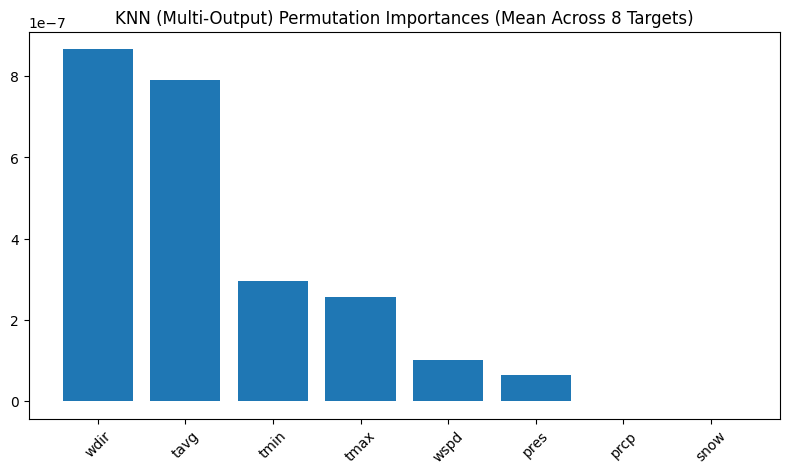

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# 1. Load Dataset
url = "https://raw.githubusercontent.com/apownukepcc/spring-2025-datathon/main/009-Dataset-For-Predictions-With-Specific-Emissions.csv"
df = pd.read_csv(url)

# 2. Convert date column and define special test date
df['date'] = pd.to_datetime(df['date'])
specific_test_date = pd.to_datetime("2022-07-15")

if specific_test_date not in df['date'].values:
    raise ValueError(f"No data available for {specific_test_date}")

# Extract and remove that row from the main dataset
specific_test_row = df[df['date'] == specific_test_date]
df = df[df['date'] != specific_test_date]

# 3. Define feature and target columns
feature_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']
target_cols = [
    'SO2TONS_per_LOADMWBA', 'SO2TONS_per_LOADMWBT',
    'NH3TONS_per_LOADMWBA', 'NH3TONS_per_LOADMWBT',
    'NOXTONS_per_LOADMWBA', 'NOXTONS_per_LOADMWBT',
    'COTONS_per_LOADMWBA', 'COTONS_per_LOADMWBT'
]

# Drop rows missing relevant columns
df = df.dropna(subset=feature_cols + target_cols)

# 4. Train/Test Split
X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Append the special-date row to X_test, y_test
X_test = pd.concat([X_test, specific_test_row[feature_cols]])
y_test = pd.concat([y_test, specific_test_row[target_cols]])

# 5. Multi-Output KNN
# Wrap KNeighborsRegressor in MultiOutputRegressor for multi-target
knn = KNeighborsRegressor(n_neighbors=5)  # Example
multi_knn = MultiOutputRegressor(knn)
multi_knn.fit(X_train, y_train)

# 6. Predictions & Basic Metrics
predictions = multi_knn.predict(X_test)

mse_all = mean_squared_error(y_test, predictions, multioutput='raw_values')
mae_all = mean_absolute_error(y_test, predictions, multioutput='raw_values')
r2_all  = r2_score(y_test, predictions, multioutput='raw_values')

results = pd.DataFrame({
    'Target': target_cols,
    'MSE': mse_all,
    'MAE': mae_all,
    'R2': r2_all
})

print("\n=== Metrics for Each Target ===")
print(results)

# Compare for special date
pred_df = pd.DataFrame(predictions, columns=target_cols, index=y_test.index)
special_date_pred = pred_df.iloc[-1]
special_date_true = y_test.iloc[-1]

print(f"\n=== Comparison for {specific_test_date.date()} ===")
comparison_df = pd.DataFrame({'Actual': special_date_true, 'Predicted': special_date_pred})
print(comparison_df)

# 7. Permutation Feature Importance
# Because KNN does not have feature_importances_, we use permutation_importance
# We'll average the results across all internal KNN models (one per target)
permutation_means = []
for i, estimator in enumerate(multi_knn.estimators_):
    # Permutation importance for the i-th target
    # We pass the i-th column of y_test: y_test.iloc[:, i]
    perm_result = permutation_importance(
        estimator,
        X_test,
        y_test.iloc[:, i],    # Only the i-th target
        n_repeats=5,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    permutation_means.append(perm_result.importances_mean)

# Convert to array for averaging
permutation_means = np.array(permutation_means)  # shape = (num_targets, num_features)
avg_importances = permutation_means.mean(axis=0)

# Sort descending
sorted_idx = np.argsort(avg_importances)[::-1]

print("\n=== Permutation Importances (Averaged Across Targets) ===")
for idx in sorted_idx:
    print(f"{feature_cols[idx]}: {avg_importances[idx]:.4e}")

# 8. Plot the Averaged Permutation Importances
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_cols)), avg_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in sorted_idx], rotation=45)
plt.title("KNN (Multi-Output) Permutation Importances (Mean Across 8 Targets)")
plt.tight_layout()
plt.show()
